## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [32]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.3, l='L2', l_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if l == 'L2':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(l_ratio))(input_layer)
            if l == 'L1':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(l_ratio))(input_layer)
           
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            if l == 'L2':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l_ratio))(x)
            if l == 'L1':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(l_ratio))(x)
          
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="sigmoid", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [33]:
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95
L_TYPE = ['L1','L2']
L_TYPE = ['L2']
L_EXP = [1e-2, 1e-4]
Dropout_EXP = [0.25, 0.3]

In [34]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l in L_TYPE:
    for le in L_EXP:
        for de in Dropout_EXP:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            id_ = l + '_' + str(le) + '_' + str(de)
            model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=de, l=l, l_ratio=le)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            model.fit(x_train, y_train, 
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE, 
                      validation_data=(x_test, y_test), 
                      shuffle=True)

            # Collect results
            results[id_]= {
                'train_loss' : model.history.history["loss"]
                ,'valid_loss' : model.history.history["val_loss"]
                ,'train_acc' : model.history.history["acc"]
                ,'valid_acc' : model.history.history["val_acc"]
                }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 14s 276us/step - loss: 14.9435 - acc: 0.2318 - val_loss: 14.5661 - val_acc: 0.2945
Epoch 4/30
50000/50000 [==============================] - 14s 274us/step - loss: 14.4031 - acc: 0.2491 - val_loss: 14.0527 - val_acc: 0.2883
Epoch 5/30
50000/50000 [==============================] - 14s 279us/step - loss: 13.8909 - acc: 0.2607 - val_loss: 13.5652 - val_acc: 0.2986
Epoch 6/30
50000/50000 [==============================] - 13s 260us/step - loss: 13.4023 - acc: 0.2739 - val_loss: 13.0934 - val_acc: 0.3001
Epoch 7/30
50000/50000 [==============================] - 13s 259us/step - loss: 12.9394 - acc: 0.2853 - val_loss: 12.6381 - val_acc: 0.3172
Epoch 8/30
50000/50000 [==============================] - 13s 257us/step - loss: 12.5002 - acc: 0.2926 - val_loss: 12.2084 - val_acc: 0.3205
Epoch 9/30
50000/50000 [==============================] - 13s 257us/step - loss: 12.0735 - acc: 0.2951 - val_loss: 11.8026 - val_acc: 0.3252
Epoch 10/30
50000/50000 

50000/50000 [==============================] - 13s 267us/step - loss: 1.9742 - acc: 0.3432 - val_loss: 1.9175 - val_acc: 0.3771
Epoch 19/30
50000/50000 [==============================] - 13s 269us/step - loss: 1.9626 - acc: 0.3466 - val_loss: 1.9024 - val_acc: 0.3746
Epoch 20/30
50000/50000 [==============================] - 14s 280us/step - loss: 1.9564 - acc: 0.3494 - val_loss: 1.8968 - val_acc: 0.3779
Epoch 21/30
50000/50000 [==============================] - 14s 275us/step - loss: 1.9450 - acc: 0.3488 - val_loss: 1.8952 - val_acc: 0.3865
Epoch 22/30
50000/50000 [==============================] - 13s 270us/step - loss: 1.9377 - acc: 0.3511 - val_loss: 1.8818 - val_acc: 0.3834
Epoch 23/30
50000/50000 [==============================] - 14s 278us/step - loss: 1.9284 - acc: 0.3561 - val_loss: 1.8725 - val_acc: 0.3934
Epoch 24/30
50000/50000 [==============================] - 15s 294us/step - loss: 1.9236 - acc: 0.3574 - val_loss: 1.8650 - val_acc: 0.3925
Epoch 25/30
50000/50000 [=======

0 L1_0.01_0.25
1 L1_0.01_0.3
2 L1_0.01_0.5
3 L1_0.0001_0.25
4 L1_0.0001_0.3
5 L1_0.0001_0.5
6 L1_1e-08_0.25
7 L1_1e-08_0.3
8 L1_1e-08_0.5


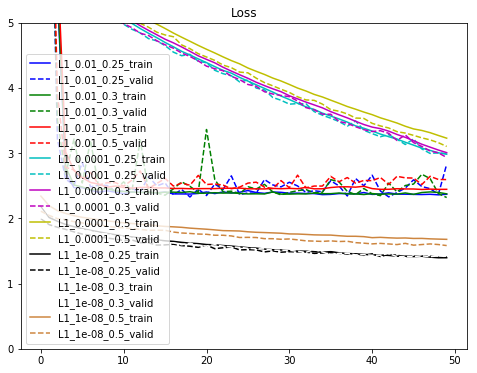

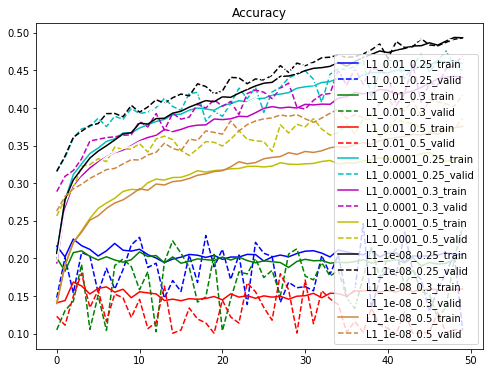

In [27]:
import matplotlib.pyplot as plt
from collections import OrderedDict

cmaps = OrderedDict()
%matplotlib inline
color_bar = ['b','g','r','c','m','y','k','w','peru']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(i, cond)
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

0 L2_0.01_0.25
1 L2_0.01_0.3
2 L2_0.0001_0.25
3 L2_0.0001_0.3


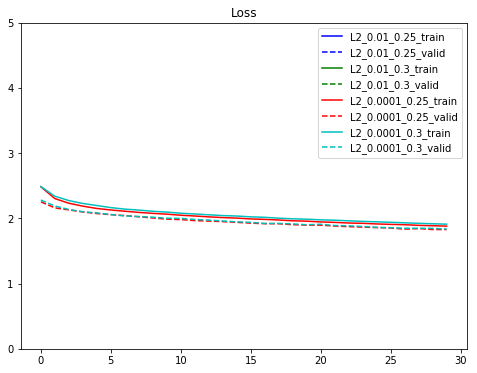

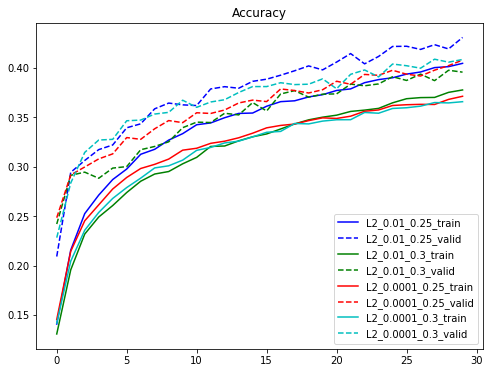

In [35]:
import matplotlib.pyplot as plt
from collections import OrderedDict

cmaps = OrderedDict()
%matplotlib inline
color_bar = ['b','g','r','c','m','y','k','w','peru']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    print(i, cond)
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=str(cond)+'_train', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=str(cond)+'_valid', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()